In [1]:
%matplotlib widget
import numpy as np
from astropy import units as u, constants as c
import matplotlib.pyplot as plt
from astropy.cosmology import Planck18 as cosmo
import matplotlib
from astropy.convolution import convolve, Gaussian2DKernel
from scipy import interpolate

In [8]:


# all from Chen+20

cnfw = 3.3 # NFW concentration parameter
z = 2.3 # redshift
Rs = 27*u.kpc # = Rvir = 90 kpc
H = cosmo.H(z)

# outflow
vi = 603*u.km/u.s #603*u.km/u.s
M_h = 1e12*u.M_sun
rho0 = 3*M_h/(4*np.pi*Rs**3) *0.5
A = 8*np.pi*c.G*rho0*Rs**3/(1*u.kpc)

rmax = 307*u.kpc #307

# inflow
voff = -80 * u.km/u.s


# alpha

gin = 0.58
gout = 2.0
a0out = 0.031
a0in = 0.0083


def vels(r):
    vout = np.sqrt(vi**2 + A*(-np.log((Rs.value+1)/Rs.value) + (1/r.value * np.log((Rs+r)/Rs))))
    
    vin = voff + H*r
    return vout, vin

def alphas(r):
    # print(r)
    # alpha
    if r > rmax:
        aout=0
    else:
        aout = (a0out * (r/(100*u.kpc))**(-gout)).value
    ain = (a0in * (r/(100*u.kpc))**(-gin)).value

    return aout, ain



In [9]:
alphas(50*u.kpc)

(0.124, 0.012407248763669988)

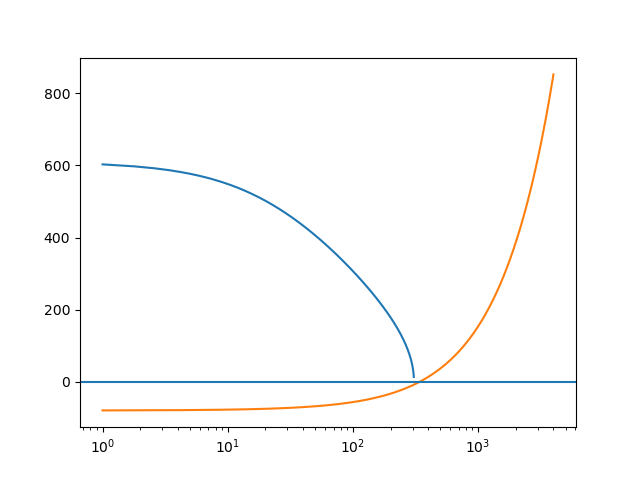

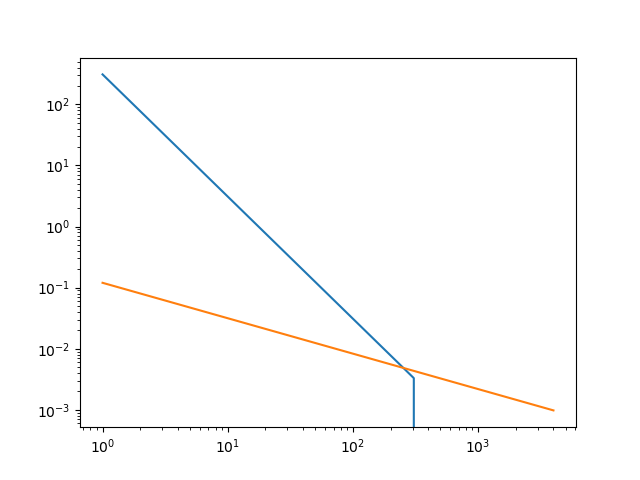

In [10]:
r = np.linspace(1, 4000, 5000) * u.kpc
vout, vin = vels(r)
plt.figure()
plt.semilogx(r, vout)
plt.semilogx(r, vin)
plt.axhline(0)
plt.show()

aout = [alphas(ri) for ri in r]
# print(aout)

plt.figure()
plt.loglog(r, aout)
# plt.loglog(r, ain)
plt.show()

In [36]:
r = 10*u.kpc
va(r)

(<Quantity 488.06365944 km / s>,
 <Quantity -81.66819856 km / s>,
 <Quantity 3.1>,
 <Quantity 0.03155572>)

In [175]:
# deproject
# lres = 2 # kpc
bres = 5 # kpc

# min_l = 0 # kpc
min_b = 10 # kpc

# max_l = 70 # 4000 kpc # up and back down to zero
max_b = 100 # kpc

# lvec = np.arange(min_l, max_l, lres)
bvec = np.arange(min_b, max_b, bres)

# bb, ll = np.meshgrid(bvec, lvec)
# print(bb,ll)


# hmap = np.zeros((len(lvec), len(bvec)))

taulist_out = []
taulist_in = []


for bi, b in enumerate(bvec):
    if b > rmax.value:
        for vv in range(-600,600):
            taulist.append([b,vv, 0])
        continue
    # if bi == 15:
    print(b)

    lmax = np.sqrt(rmax**2 - (b*u.kpc)**2)
    # print(lmax)

    larr_slowl = np.linspace(-lmax.value, -50, 50)
    nfast = int(800 * np.exp(-b/50))
    # print(nfast)
    larr_fast = np.linspace(-50, 50, nfast)
    larr_slowr = np.linspace(50, lmax.value, 50)
    larr = np.concatenate([larr_slowl, larr_fast, larr_slowr])
    
    # larr = np.linspace(-lmax.value, lmax.value, 50)
    tau_outs = [alphas(np.sqrt((b*u.kpc)**2 + (li*u.kpc)**2))[0] for li in larr]
    
    tau_ins = [alphas(np.sqrt((b*u.kpc)**2 + (li*u.kpc)**2))[1] for li in larr]
    # print(tau_outs)
    # taus = [np.trapz(alphas(np.sqrt((b*u.kpc)**2 + (li*u.kpc)**2))[0].value, x=larr[0:li]) for li in larr]
    # plt.figure()
    # plt.plot(larr, tau_outs)
    # plt.plot(larr, tau_ins)
    # plt.show()

    r = np.sqrt(larr**2 + b**2)
    vout, vin = vels(r*u.kpc)
    # print(vout)
    # plt.figure()
    # plt.plot(larr, vout)
    # plt.plot(larr, vin)
    # plt.show()

    vLOS_out = larr/r*vout
    vLOS_in = larr/r*vin
    # plt.figure()
    # sc = plt.scatter(larr, vLOS_out, c=tau_outs)
    # sc1 = plt.scatter(larr, vLOS_in, c=tau_ins, cmap='inferno')
    # plt.colorbar(sc)
    # plt.colorbar(sc1)
    # plt.show()

    
    l_minvout = larr[np.argmin(vLOS_out)]
    l_maxvout = larr[np.argmax(vLOS_out)]
    maxvout = np.nanmax(vLOS_out.value)
    
    # outflow
    for i in range(int(np.floor(-maxvout)), int(np.ceil(maxvout)), 10):
    
        possible_values = larr[(vLOS_out.value > i) & (vLOS_out.value < i+10)]
        l_near = possible_values[(possible_values > l_minvout) & (possible_values < l_maxvout)]
        l_far = possible_values[(possible_values < l_minvout) | (possible_values > l_maxvout)]

        tau_near_inds = [np.argwhere(larr == ln)[0][0] for ln in l_near]
        tau_out_near = np.array(tau_outs)[tau_near_inds]

        
        tau_far_inds = [np.argwhere(larr == ln)[0][0] for ln in l_far]
        tau_out_far = np.array(tau_outs)[tau_far_inds]
        tau_tot = np.nanmean(tau_out_near) + np.nanmean(tau_out_far) 
        
        taulist_out.append([b, i+5, tau_tot])


    #inflow

    l_minvin = larr[np.argmin(vLOS_in)]
    l_maxvin = larr[np.argmax(vLOS_in)]
    maxvin = np.nanmax(vLOS_in.value)
    print(l_minvin, l_maxvin, maxvin)
    
    for i in range(int(np.floor(-maxvin)), int(np.ceil(maxvin)), 10):
    
        possible_values = larr[(vLOS_in.value > i) & (vLOS_in.value < i+10)]
        # print(possible_values)
        l_near = possible_values[(possible_values < l_minvin) & (possible_values > l_maxvin)]
        l_far = possible_values[(possible_values > l_minvin) | (possible_values < l_maxvin)]

        tau_near_inds = [np.argwhere(larr == ln)[0][0] for ln in l_near]
        tau_in_near = np.array(tau_ins)[tau_near_inds]

        
        tau_far_inds = [np.argwhere(larr == ln)[0][0] for ln in l_far]
        tau_in_far = np.array(tau_ins)[tau_far_inds]
        tau_tot = np.nanmean(tau_in_near) + np.nanmean(tau_in_far) 
        # print(tau_tot)
        
        taulist_in.append([b, i+5, tau_tot])
        
            
        
        # vLOS_max_ind = np.argmax(lvec/r*vout)
        # lmax = lvec[vLOS_max_ind]
        # lvec_b = np.linspace(0, lmax, 50)
        # print(lmax)
        
    # print(b, tau_out)
        # for li, l in enumerate(lvec_b):
        #     r = np.sqrt(l**2 + b**2)
        #     vout, vin = vels(r*u.kpc)
        #     # print(vout)
        #     vLOS_out = l/r*vout
        #     # vLOS_in = l/r*vin
        #     vLOS = vLOS_out #+ vLOS_in
        #     # print(vLOS) 
        #     # print(vLOS)
        #     # print(r, vout, vLOS_out)
        
        
        #     tau_out = tau_max - np.trapz(a0out * (np.sqrt(lvec_b[0:li]**2+b**2)/100)**(-gout), x=lvec_b[0:li])
        #     # tau_in = tau_max - np.trapz(a0in * (np.sqrt(lvec_b[0:li]**2+b**2)/100)**(-gin), x=lvec_b[0:li])
        #     tau = tau_out #+ tau_in
        #     # print(tau)
        #     # if bi == 5:
        #             # print(tau)
                
        #     taus.append([b, vLOS.value, tau])
    
# for li, l in enumerate(lvec): #going row by row
#     for bi, b in enumerate(bvec):
#         if bi == 0:
#             print(b, l)
#             r = np.sqrt(l**2 + b**2)

# #         # print(r)
#             vouti, vini, aouti, aini = va(r*u.kpc)
# #         # print(vouti)
#             vLOS_out = l/r*vouti
# #         vLOS_in = l/r*vini

# #         vLOS = vLOS_out + vLOS_in

#         lrange = np.linspace(0,l, 100)
        
#             tau_out = np.trapz(a0out * (lrange**2+b**2)**(-gout), x=lrange)
# #         tau_in = np.trapz(a0in * (lrange**2+b**2)**(-gin), x=lrange)
# #         tau = tau_out + tau_in
        
#         # print(vLOS, b, aouti, tau)
#         taus.append([b, vLOS.value, tau])
# # print(taus)
tauarr_out = np.array(taulist_out)
tauarr_in = np.array(taulist_in)
# print(tauarr)


10


/tmp/ipykernel_2744106/3459065386.py:88: RuntimeWarning: Mean of empty slice
  tau_tot = np.nanmean(tau_out_near) + np.nanmean(tau_out_far)
/tmp/ipykernel_2744106/3459065386.py:113: RuntimeWarning: Mean of empty slice
  tau_tot = np.nanmean(tau_in_near) + np.nanmean(tau_in_far)


31.470137825421133 -31.470137825421133 72.71726925531449
15
40.524534686971236 -40.524534686971236 69.32713067819343
20
48.50467289719626 -48.504672897196265 66.3471304134093
25
55.22408962303281 -55.224089623032796 63.64670475637823
30
60.429823912513996 -60.429823912513996 61.14757515172851
35
65.61214452967339 -65.61214452967337 58.81498170055715
40
70.76595775032888 -70.76595775032885 56.62524331458993
45
75.88612717730989 -75.8861271773099 54.556635295993495
50
80.96746619394523 -80.9674661939452 52.590703179476144
55
86.00473010966817 -86.00473010966817 50.71227226501632
60
90.9926079447116 -90.99260794471161 48.909044682047224
65
95.92571379598365 -95.92571379598365 47.17111684902828
70
100.79857772041618 -100.79857772041618 45.490533500189045
75
100.55057824110897 -100.55057824110898 43.88609638536204
80
105.31278606919491 -105.31278606919491 42.33231268080681
85
109.99958491752082 -109.99958491752082 40.81812728328852
90
109.63546912398905 -109.63546912398905 39.36094922656401

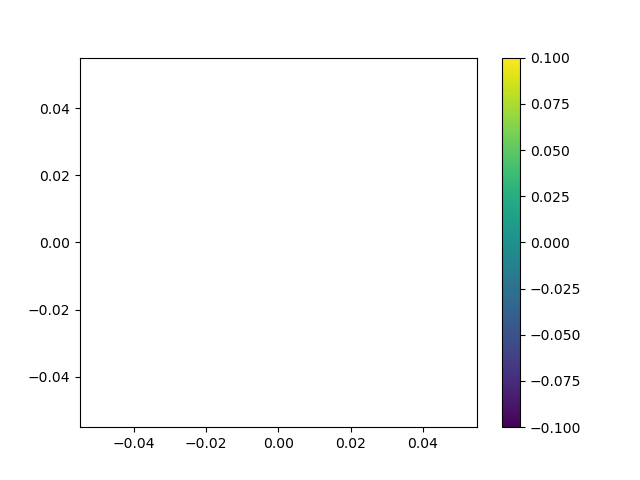

In [125]:
plt.figure()
p = plt.scatter(tauarr[:,1][tauarr[:,0] == 100], tauarr[:,2][tauarr[:,0] == 100], c = lvec_b)
plt.colorbar(p)
plt.show()

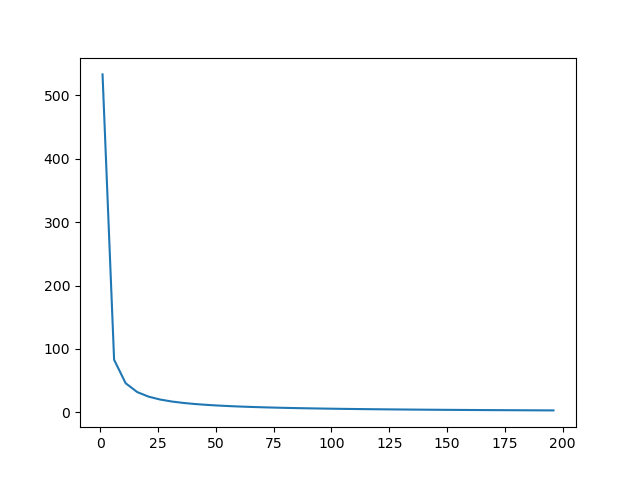

In [18]:
plt.figure()
# plt.plot(lvec, tauarr[:,1])
plt.plot(tauarr[:,0], tauarr[:,1])
plt.show()
# tauarr[:,1]

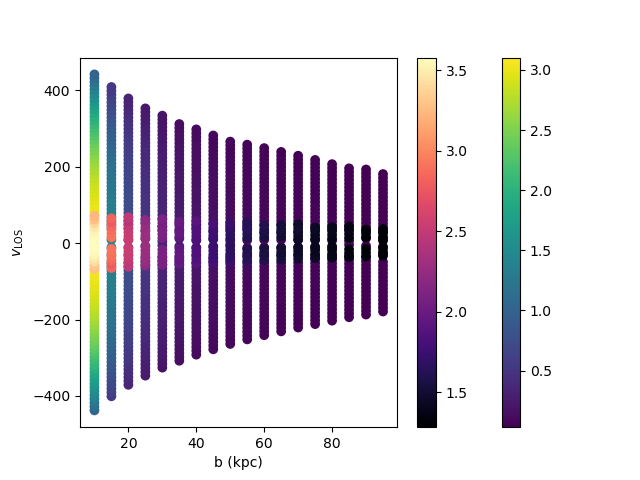

In [176]:
plt.figure()
sc = plt.scatter(tauarr_out[:,0], tauarr_out[:,1], c=tauarr_out[:,2]) #/cmap='inferno_r' vmin=2e-2, vmax = 1e-1 norm=matplotlib.colors.LogNorm()
plt.colorbar(sc)

tin = plt.scatter(tauarr_in[:,0], tauarr_in[:,1], c=tauarr_in[:,2], cmap='magma') #/cmap='inferno_r' vmin=2e-2, vmax = 1e-1 norm=matplotlib.colors.LogNorm()
plt.colorbar(tin)
plt.xlabel('b (kpc)')
plt.ylabel('$v_\\mathrm{LOS}$')
plt.show()

In [177]:
vres = 25
vlosr = np.arange(-1000, 1000, vres)

# print(len(bvec))
hmap = np.zeros((len(vlosr), len(bvec)))

for bi, b in enumerate(bvec):
    bcut_out = (tauarr_out[:,0] == b)
    bcut_in = (tauarr_in[:,0] == b)

    for vind, v in enumerate(vlosr):
        vcut_out = (tauarr_out[:,1] > v) & (tauarr_out[:,1] < v+vres)
        vcut_in = (tauarr_in[:,1] > v) & (tauarr_in[:,1] < v+vres)
        
        tauavg_out = np.nanmean(tauarr_out[:,2][bcut_out & vcut_out])
        if ~np.isfinite(tauavg_out):
            tauavg_out = 0

        tauavg_in = np.nanmean(tauarr_in[:,2][bcut_in & vcut_in])
        if ~np.isfinite(tauavg_in):
            tauavg_in = 0
        # print(tauavg)

    # vLOSorig = tauarr[:,1][bcut]
    # tauorig = tauarr[:,2][bcut]
    # tauinterp = interpolate.interp1d(vLOSorig, tauorig, bounds_error = False, fill_value = (0,0), assume_sorted=False)
    # plt.figure()
    # plt.plot(vLOSorig, tauorig, '.')
    # plt.plot(vlosr, tauinterp(vlosr), '.')
    # plt.show()
        hmap[vind,bi] = tauavg_out + tauavg_in
    


/tmp/ipykernel_2744106/3441036313.py:15: RuntimeWarning: Mean of empty slice
  tauavg_out = np.nanmean(tauarr_out[:,2][bcut_out & vcut_out])
/tmp/ipykernel_2744106/3441036313.py:19: RuntimeWarning: Mean of empty slice
  tauavg_in = np.nanmean(tauarr_in[:,2][bcut_in & vcut_in])


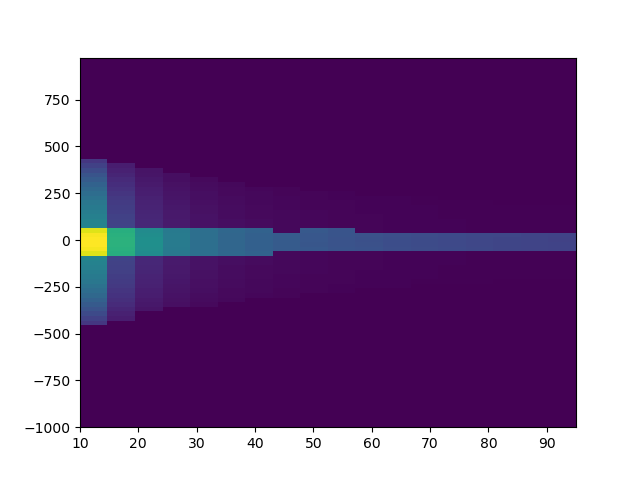

In [178]:
plt.figure()
plt.imshow(hmap, origin='lower', extent = (bvec[0], bvec[-1], vlosr[0], vlosr[-1]), aspect='auto')
plt.show()

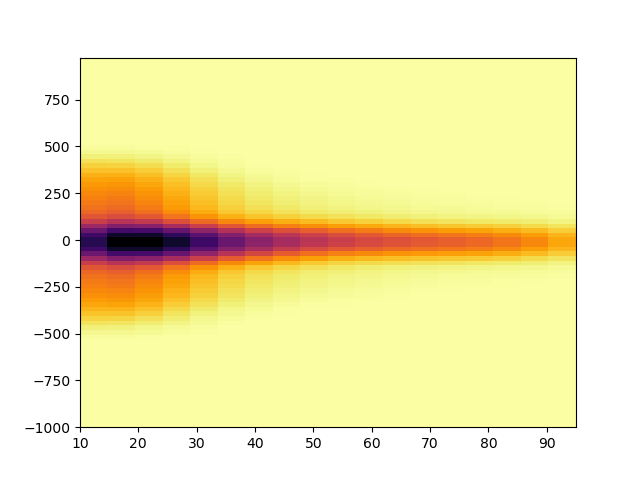

In [179]:
plt.figure()
plt.imshow(convolve(hmap, Gaussian2DKernel(2,2)), origin='lower', extent = (bvec[0], bvec[-1], vlosr[0], vlosr[-1]), 
           aspect='auto', cmap='inferno_r')
# plt.xscale('log')
plt.show()

0
2
4
6
8
10
12
14
16
18
20
22
24
26
28
30
32
34
36
38
40
42
44
46
48
50
52
54
56
58
60
62
64
66
68
70
72
74
76
78
80
82
84
86
88
90
92
94
96
98
100
102
104
106
108
110
112
114
116
118
120
122
124
126
128
130
132
134
136
138
140
142
144
146
148
150
152
154
156
158
160
162
164
166
168
170
172
174
176
178
180
182
184
186
188
190
192
194
196
198
200
202
204
206
208
210
212
214
216
218
220
222
224
226
228
230
232
234
236
238
240
242
244
246
248
250
252
254
256
258
260
262
264
266
268
270
272
274
276
278
280
282
284
286
288
290
292
294
296
298


/tmp/ipykernel_2582242/1994037565.py:11: RuntimeWarning: Mean of empty slice
  taus.append(np.nanmean(taui))


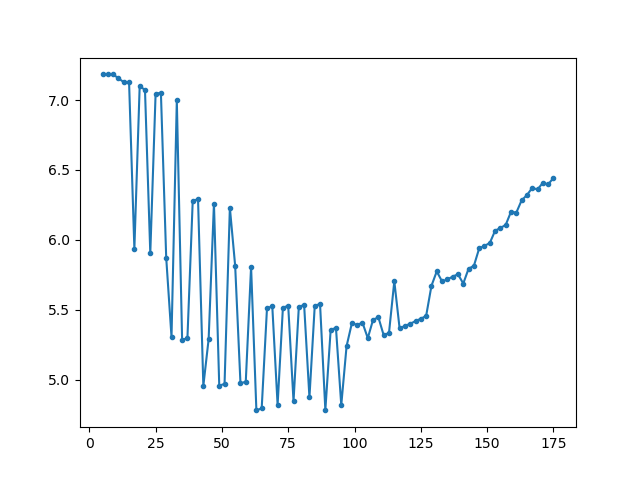

In [43]:
vs = []
taus = []

for i in range(0, 300, 2):
    print(i)
    vcut = (tauarr[:,1] > i) & (tauarr[:,1] < i+10)
    vi = i+5
    vs.append(vi)
    taui = tauarr[:,2][vcut]
    # print(taui)
    taus.append(np.nanmean(taui))



plt.figure()
plt.plot(vs, taus, '.-')
plt.show()

NameError: name 'rs' is not defined

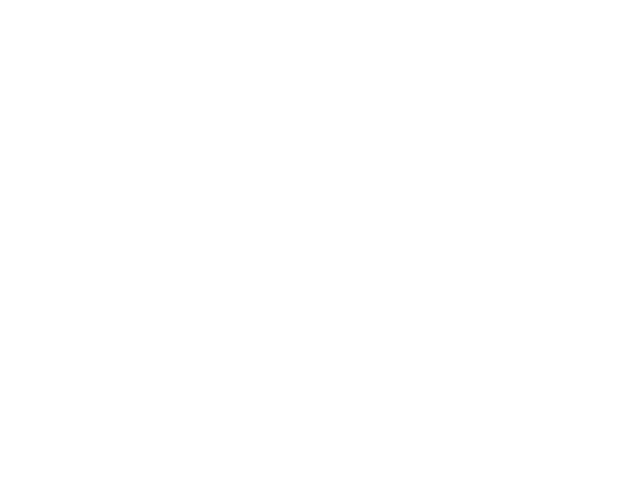

In [95]:
plt.figure()
plt.hist(rs, bins = 500)
plt.show()

<>:4: SyntaxWarning: invalid escape sequence '\e'
<>:4: SyntaxWarning: invalid escape sequence '\e'
/tmp/ipykernel_2255874/3787595886.py:4: SyntaxWarning: invalid escape sequence '\e'
  plt.ylabel('$\ell$')


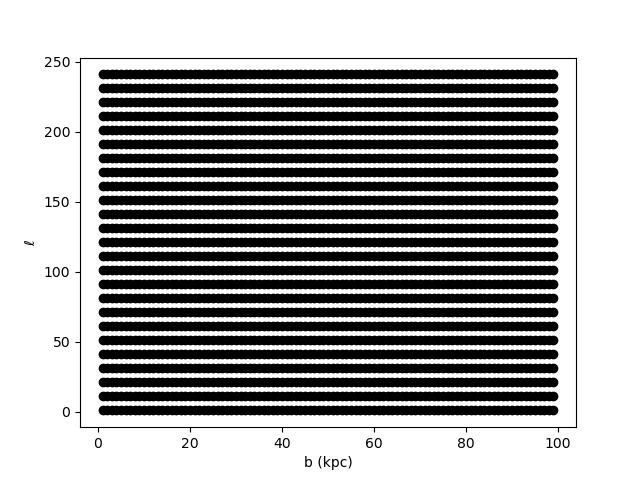

In [106]:
plt.figure()
sc = plt.plot(bb, ll, marker='o', color='k', linestyle='none') #/cmap='inferno_r'
plt.xlabel('b (kpc)')
plt.ylabel('$\ell$')
plt.show()

In [6]:
1000 *u.km/u.s/H

<Quantity 4.28852981 Mpc>

In [58]:
# deproject
bres = 1 # kpc
vres = 1 # km/s

min_vlos = 1 # km/s
min_b = 1 # kpc

max_vlos = 1000 # km/s
max_b = 250 # kpc

vvec = np.arange(min_vlos, max_vlos, vres)
bvec = np.arange(min_b, max_b, bres)

hmap = np.zeros((len(vvec), len(bvec)))
for vi, vlos in enumerate(vvec): #going row by row
    l = (vlos * u.km/u.s / H).to(u.kpc).value
    # print(l)
    for bi, b in bvec:
        r = np.sqrt(l**2 + b**2)
        
# plt.imshow(hmap, origin='lower', aspect='auto', extent = (min_b, max_b, min_vlos, max_vlos))




4.288529814058234
8.577059628116467
12.865589442174704
17.154119256232935
21.44264907029117
25.731178884349408
30.01970869840764
34.30823851246587
38.596768326524106
42.88529814058234
47.17382795464058
51.462357768698816
55.750887582757045
60.03941739681528
64.3279472108735
68.61647702493174
72.90500683898998
77.19353665304821
81.48206646710645
85.77059628116469
90.05912609522292
94.34765590928116
98.6361857233394
102.92471553739763
107.21324535145585
111.50177516551409
115.79030497957233
120.07883479363056
124.3673646076888
128.655894421747
132.94442423580526
137.23295404986348
141.5214838639217
145.81001367797995
150.09854349203817
154.38707330609643
158.67560312015468
162.9641329342129
167.25266274827115
171.54119256232937
175.82972237638762
180.11825219044584
184.4067820045041
188.69531181856232
192.98384163262054
197.2723714466788
201.560901260737
205.84943107479526
210.13796088885348
214.4264907029117
218.71502051696996
223.00355033102818
227.29208014508643
231.58060995914465
235